### LSTM - Input: 'Close/Last', 'Open', 'High', 'Low'

In [1]:
import pandas as pd
import numpy as np
# Load the data
data = pd.read_csv("Data_input_1.csv")

# Check for missing values
print(data.isnull().sum())

# Fill missing values or drop rows with missing values
data.fillna(method='ffill', inplace=True)  # forward fill
data.dropna(inplace=True)  # drop any remaining NaNs


Date          0
Close/Last    0
Open          0
High          0
Low           0
dtype: int64


C:\Users\DELL\AppData\Local\Temp\ipykernel_8732\4277517028.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # forward fill


In [2]:
data['Date'] = pd.to_datetime(data['Date'])

# Tạo các cột phụ để sắp xếp theo năm, tháng, ngày
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Sắp xếp DataFrame theo năm, sau đó tháng, và cuối cùng là ngày
data.sort_values(['Year', 'Month', 'Day'], inplace=True)

# Xóa các cột phụ nếu không cần thiết
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)
data

,Date,Close/Last,Open,High,Low
1257,2019-06-03,4170.02,4255.18,4264.98,4145.45
1256,2019-06-04,4320.98,4230.68,4322.79,4199.29
1255,2019-06-05,4329.21,4359.99,4372.12,4279.17
1254,2019-06-06,4375.45,4338.55,4388.83,4321.69
1253,2019-06-07,4435.80,4398.04,4453.16,4390.15
...,...,...,...,...,...
4,2024-05-23,10495.82,10698.18,10704.39,10444.49
3,2024-05-24,10549.22,10494.50,10616.85,10480.60
2,2024-05-28,10526.85,10592.65,10594.29,10462.57
1,2024-05-29,10396.40,10386.55,10451.02,10386.55


In [3]:
# Tính toán số lượng dòng cho từng phần
total_rows = len(data)
train_size = int(0.8 * total_rows)
val_size = int(0.1 * total_rows)
test_size = total_rows - train_size - val_size  # Đảm bảo rằng tổng số dòng vẫn bằng total_rows

# Chia DataFrame thành các tập huấn luyện, kiểm tra và kiểm định
data_train = data.iloc[:train_size]
data_val = data.iloc[train_size:train_size + val_size]
data_test = data.iloc[train_size + val_size:]

In [4]:
data_test

,Date,Close/Last,Open,High,Low
126,2023-11-28,8739.96,8661.84,8753.15,8661.15
125,2023-11-29,8874.27,8872.32,8963.51,8863.59
124,2023-11-30,8850.47,8898.31,8924.81,8765.49
123,2023-12-01,8878.94,8797.75,8883.24,8759.92
122,2023-12-04,8767.82,8785.59,8791.24,8637.88
...,...,...,...,...,...
4,2024-05-23,10495.82,10698.18,10704.39,10444.49
3,2024-05-24,10549.22,10494.50,10616.85,10480.60
2,2024-05-28,10526.85,10592.65,10594.29,10462.57
1,2024-05-29,10396.40,10386.55,10451.02,10386.55


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Chuẩn hóa các cột giá dựa trên tập huấn luyện và áp dụng cho tập kiểm tra và kiểm định
scaler_price = MinMaxScaler(feature_range=(-1, 1))
price_columns = ['Close/Last', 'Open', 'High', 'Low']
data_train_copy=data_train[price_columns]
data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
data_val[price_columns] = scaler_price.transform(data_val[price_columns])
data_test_copy=data_test[price_columns]
data_test[price_columns] = scaler_price.transform(data_test[price_columns])

# Chuyển đổi các cột pandas thành mảng NumPy
train_data = data_train[price_columns].values
val_data = data_val[price_columns].values
test_data = data_test[price_columns].values

# Hiển thị kích thước của các tập dữ liệu
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (1006, 4)
Validation data shape: (125, 4)
Test data shape: (127, 4)


C:\Users\DELL\AppData\Local\Temp\ipykernel_8732\447585929.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train[price_columns] = scaler_price.fit_transform(data_train[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_8732\447585929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_val[price_columns] = scaler_price.transform(data_val[price_columns])
C:\Users\DELL\AppData\Local\Temp\ipykernel_8732\447585929.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [6]:
# Training data
seq_len = 30
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 0][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 0][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 0][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print( X_train.shape, y_train.shape)
print( X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(976, 30, 4) (976,)
(95, 30, 4) (95,)
(97, 30, 4) (97,)


In [7]:
type(X_test)

numpy.ndarray

In [8]:
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.models import Sequential

# model = Sequential([
#     LSTM(256),
#     Dropout(0.3),
#     LSTM(256),
#     Dropout(0.3),
#     Dense(1)
# ])
model = Sequential([
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(256),
    Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val), verbose=1)

# Predicting and reversing normalization
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler_price.inverse_transform(np.concatenate((predicted_stock_price, np.zeros((len(predicted_stock_price), 3))), axis=1))[:,0]

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - loss: 0.1280 - val_loss: 0.0272
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - loss: 0.0188 - val_loss: 0.0103
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - loss: 0.0098 - val_loss: 0.0082
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - loss: 0.0079 - val_loss: 0.0066
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - loss: 0.0076 - val_loss: 0.0063
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 431ms/step - loss: 0.0069 - val_loss: 0.0058
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 485ms/step - loss: 0.0061 - val_loss: 0.0054
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 464ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 431ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 481ms/step - loss: 0.0

In [9]:
predict = model.predict(X_test[0][np.newaxis, :, :])
predict = scaler_price.inverse_transform(np.concatenate((predict, np.zeros((len(predict), 3))), axis=1))[:,0]
predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


array([9463.07375271])

In [10]:
X_test[0][np.newaxis, :, :]

array([[[0.61698643, 0.57924702, 0.59221692, 0.60360263],
        [0.66310422, 0.65143725, 0.66530185, 0.67186515],
        [0.65493206, 0.66035128, 0.65185639, 0.63878595],
        [0.66470775, 0.62586131, 0.63741382, 0.63690775],
        [0.62655267, 0.62169068, 0.60545045, 0.59575602],
        [0.62012138, 0.58908366, 0.59143868, 0.60508293],
        [0.59878104, 0.63500513, 0.61892718, 0.60992511],
        [0.65374057, 0.60618803, 0.6299997 , 0.62325795],
        [0.66749933, 0.62469175, 0.64554363, 0.64732045],
        [0.73906072, 0.67154269, 0.71957704, 0.69357063],
        [0.76970633, 0.71846222, 0.74287556, 0.73861701],
        [0.81314929, 0.76571444, 0.79482298, 0.772347  ],
        [0.84523019, 0.82308798, 0.83885252, 0.82489606],
        [0.87241809, 0.85360625, 0.86719568, 0.86610512],
        [0.86946168, 0.85955351, 0.85089089, 0.85923638],
        [0.8830625 , 0.86035951, 0.86170285, 0.88021014],
        [0.82453881, 0.85470722, 0.86420433, 0.83360927],
        [0.885

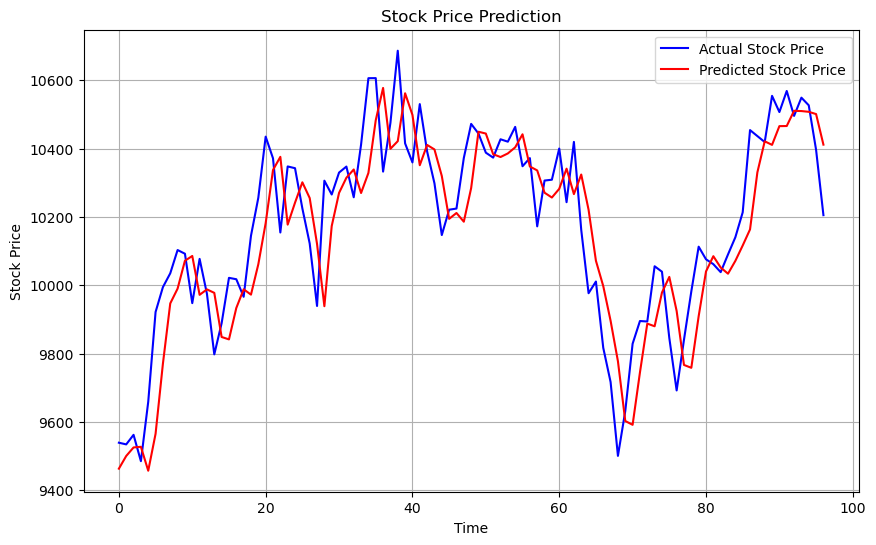

Root Mean Squared Error: 145.32983317289003
Mean Absolute Percentage Error: 0.011601542838330581


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Get actual prices from the last part of the test set
actual_prices = data_test_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = mean_squared_error(actual_prices, predicted_stock_price, squared=False)
print(f"Root Mean Squared Error: {rmse}")

mape = mean_absolute_percentage_error(actual_prices, predicted_stock_price)
print(f"Mean Absolute Percentage Error: {mape}")


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


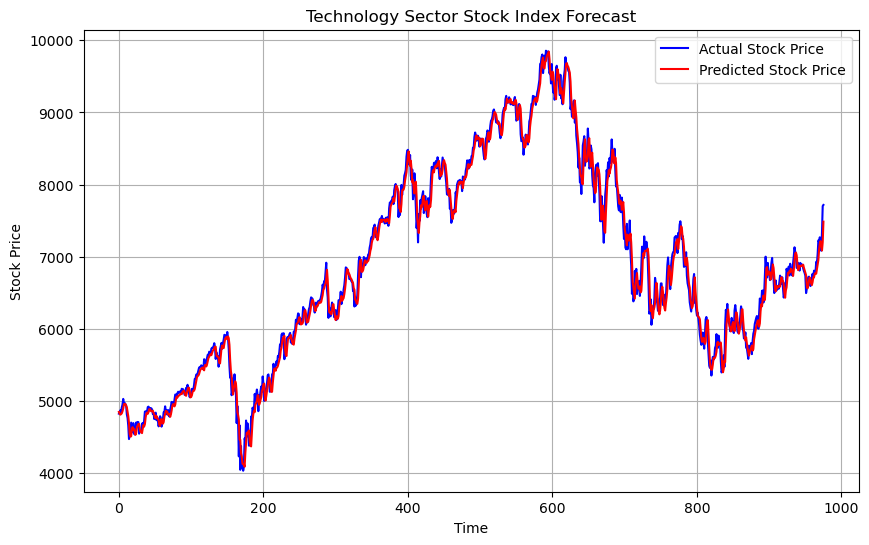

In [12]:
predicted_stock_price_train = model.predict(X_train)
predicted_stock_price_train = scaler_price.inverse_transform(np.concatenate((predicted_stock_price_train, np.zeros((len(predicted_stock_price_train), 3))), axis=1))[:,0]
actual_train_prices = data_train_copy['Close/Last'].values[seq_len:]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(actual_train_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price_train, color='red', label='Predicted Stock Price')
plt.title('Technology Sector Stock Index Forecast')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# model.save('2_layerLSTMMain.h5')

In [14]:
import joblib 

In [15]:
# joblib.dump(scaler_price, 'scaler_price_main2lstm.pkl')

In [16]:
# np.save('X_test12.npy', X_test)
